In [1]:
## Importing the required Packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, time
import joblib
# to display all columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
from pylab import rcParams

In [3]:
import copy
import statistics
import scipy
import scipy.stats as stats
import statsmodels.api as sm

#### import pickled dataset

In [4]:
# load pickled dataset
df_train_fs = joblib.load("df_train_fs.pkl")
df_train_fs.shape

(550068, 100)

In [5]:
# ANOVA Features Selection List
anova_features_lst = joblib.load('anova_features_lst.pkl')
len(anova_features_lst)  

25

In [6]:
# Step Backward feature selection columns
bfs_features_lst = joblib.load('bfs_features_lst.pkl')
len(bfs_features_lst)

25

In [7]:
# lasso feature selection columns
lasso_features_f_list = joblib.load('lasso_features_f_list.pkl')
len(lasso_features_f_list)

27

In [8]:
# Tree based Random Forest Regressor feature selection columns
rfr_features_lst = joblib.load('rfr_features_lst.pkl')
len(rfr_features_lst) 

25

In [9]:
# ExtraTrees Feature important selection list
extratrees_feature_lst = joblib.load('extratrees_feature_lst.pkl')
len(extratrees_feature_lst)

25

In [10]:
#### column names
df_train_fs.columns

Index(['Occupation', 'Marital_Status', 'Purchase', 'Product_ID_Rare',
       'Product_Category_1_Rare', 'Product_Category_2_Rare',
       'Product_Category_3_Rare', 'Gender_le', 'ohe_city_A', 'ohe_city_B',
       'ohe_city_C', 'f_product_tot_sale_amt', 'f_product_id_m',
       'f_product_id_median', 'f_product_id_min', 'f_product_id_max',
       'f_product_id_std', 'f_gender_unique_users_cnt', 'f_age_m',
       'f_age_median', 'f_age_std', 'f_Age_Min', 'f_Age_Max', 'f_occupation_m',
       'f_occupation_tot_amt', 'f_current_city_m', 'f_current_city_median',
       'f_current_city_min', 'f_current_city_max', 'f_current_city_std',
       'f_prod_category_1_m', 'f_prod_category_1_tot_amt',
       'f_prod_category_1_median', 'f_prod_category_1_min',
       'f_prod_category_1_max', 'f_prod_category_1_std', 'f_prod_category_2_m',
       'f_prod_category_2_tot_amt', 'f_prod_category_2_median',
       'f_prod_category_2_min', 'f_prod_category_2_max',
       'f_prod_category_2_std', 'f_prod_cat

#### train and validation dataset

In [11]:
# train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(df_train_fs.drop(labels = ['Purchase'], axis = 1), df_train_fs['Purchase'], test_size = 0.2, random_state = 0 )
print(X_train.shape, y_train.shape); print(X_validation.shape, y_validation.shape)

(440054, 99) (440054,)
(110014, 99) (110014,)


#### 1. Linear Regression Model

In [36]:
%%time
# Linear Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor = regressor.fit(X_train[rfr_features_lst], y_train)
regressor_R_squared = regressor.score(X_train[rfr_features_lst], y_train)
print('R squared of Regressor model:', regressor_R_squared)

R squared of Regressor model: 0.6973208344372424
Wall time: 6.05 s


In [37]:
# Prediction of X_validation Dataset
y_validation_predict = regressor.predict(X_validation[rfr_features_lst])

#### 2. XGBoost Regressor

In [121]:
# XGBoost parameter optimizing
from sklearn.model_selection import GridSearchCV

# parameter grid
param_grid = {
              "learning_rate": [0.05, 0.1],
              "min_child_weight": [5, 8],
              "gamma" : [0],
              "reg_alpha": [0.01, 1],
              "subsample": [0.8],
              'n_estimators': [200],
              'max_depth' : [5, 8],
              "colsample_bytree" : [0.8],
              }

# StratifiedKfold
from sklearn.model_selection import StratifiedKFold 
strkfold = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

### Creation of Base model ###
from xgboost import XGBRegressor
xgbr = XGBRegressor( random_state = 0 )

# Grid Search 
grid_search = GridSearchCV(estimator = xgbr, param_grid = param_grid, cv = strkfold, n_jobs = -1, verbose = 2)

In [122]:
%%time
# Fitting the grid_search to the model ####
grid_search.fit(X_train[extratrees_feature_lst], y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 85.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 124.5min finished


Wall time: 2h 10min 50s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=Non...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0],
                         'learning_rate': [0.05, 0.1], 'max_depth': [5, 8],
                         '

In [123]:
# Grid Search Best Params
grid_search.best_params_
# filter - {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 600, 'reg_alpha': 1, 'subsample': 0.8}
# bfs - {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 0.8}
# lasso - {'colsample_bytree': 0.8,  'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 0.8}
# rfr - {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 0.8}
# extratrees - {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 200, 'reg_alpha': 1, 'subsample': 0.8}

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 8,
 'n_estimators': 200,
 'reg_alpha': 1,
 'subsample': 0.8}

In [38]:
%%time
# XGBoost Regressor
from xgboost import XGBRegressor
xgbr = XGBRegressor(colsample_bytree= 0.8, gamma= 0, learning_rate= 0.1, max_depth= 8, min_child_weight= 5, n_estimators= 200,
reg_alpha= 0.01, subsample= 0.8, random_state = 0 )
xgbr = xgbr.fit(X_train[rfr_features_lst], y_train)
xgboost_R_squared = xgbr.score(X_train[rfr_features_lst], y_train)
print('R squared of xgboost model:', xgboost_R_squared)

R squared of xgboost model: 0.7593040646327318
Wall time: 4min 9s
Parser   : 103 ms


In [42]:
# Prediction of X_validation Dataset  
y_validation_predict = xgbr.predict(X_validation[rfr_features_lst])

#### 3. Cat Boost Model

In [62]:
# Cat Boost parameter optimizing
from sklearn.model_selection import GridSearchCV

# parameter grid
param_grid = {
              "iterations": [600],
              "learning_rate": [0.05, 0.1],
              "depth" : [6, 8],
              "l2_leaf_reg" : [0.1, 1],
              "bagging_temperature" : [0, 1],
              "random_strength" : [0, 1 ]
              }

# StratifiedKfold
from sklearn.model_selection import StratifiedKFold 
strkfold = StratifiedKFold(n_splits=3, random_state=15, shuffle=True)

### Creation of Base model ###
import catboost
from catboost import CatBoostRegressor
catboostr = CatBoostRegressor(loss_function='RMSE', random_state= 15)

# Grid Search 
grid_search = GridSearchCV(estimator = catboostr, param_grid = param_grid, cv = strkfold, n_jobs = -1, verbose = 2)

In [63]:
%%time
# Fitting the grid_search to the model ####
grid_search.fit(X_train[bfs_features_lst], y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 164.1min finished


0:	learn: 4684.4420373	total: 495ms	remaining: 4m 56s
1:	learn: 4389.7405871	total: 1.17s	remaining: 5m 50s
2:	learn: 4135.4034287	total: 1.9s	remaining: 6m 17s
3:	learn: 3915.2493598	total: 2.66s	remaining: 6m 37s
4:	learn: 3725.5319596	total: 3.16s	remaining: 6m 16s
5:	learn: 3564.9055832	total: 3.6s	remaining: 5m 56s
6:	learn: 3427.2173819	total: 3.82s	remaining: 5m 23s
7:	learn: 3311.0520749	total: 4.06s	remaining: 5m
8:	learn: 3212.0402150	total: 4.33s	remaining: 4m 44s
9:	learn: 3128.8346799	total: 4.58s	remaining: 4m 30s
10:	learn: 3058.4569092	total: 4.83s	remaining: 4m 18s
11:	learn: 2999.9604019	total: 5.06s	remaining: 4m 8s
12:	learn: 2950.4302112	total: 5.31s	remaining: 3m 59s
13:	learn: 2906.6728141	total: 5.55s	remaining: 3m 52s
14:	learn: 2871.7072762	total: 5.79s	remaining: 3m 45s
15:	learn: 2842.7656286	total: 6.01s	remaining: 3m 39s
16:	learn: 2816.2567462	total: 6.24s	remaining: 3m 34s
17:	learn: 2795.8183281	total: 6.47s	remaining: 3m 29s
18:	learn: 2776.8323194	tot

150:	learn: 2598.5738800	total: 41.8s	remaining: 2m 4s
151:	learn: 2598.3131073	total: 42.3s	remaining: 2m 4s
152:	learn: 2597.7401355	total: 42.8s	remaining: 2m 4s
153:	learn: 2597.4404092	total: 43.1s	remaining: 2m 4s
154:	learn: 2596.9362929	total: 43.3s	remaining: 2m 4s
155:	learn: 2596.3331148	total: 43.6s	remaining: 2m 4s
156:	learn: 2596.0313701	total: 43.8s	remaining: 2m 3s
157:	learn: 2595.7290209	total: 44s	remaining: 2m 3s
158:	learn: 2595.3279745	total: 44.2s	remaining: 2m 2s
159:	learn: 2595.0962326	total: 44.5s	remaining: 2m 2s
160:	learn: 2594.7448873	total: 44.7s	remaining: 2m 1s
161:	learn: 2594.4517760	total: 44.9s	remaining: 2m 1s
162:	learn: 2594.2306213	total: 45.1s	remaining: 2m
163:	learn: 2594.0374167	total: 45.4s	remaining: 2m
164:	learn: 2593.5326308	total: 45.6s	remaining: 2m
165:	learn: 2593.2411049	total: 45.9s	remaining: 1m 59s
166:	learn: 2593.1100804	total: 46.1s	remaining: 1m 59s
167:	learn: 2592.8128234	total: 46.3s	remaining: 1m 59s
168:	learn: 2592.5

297:	learn: 2557.6625559	total: 1m 29s	remaining: 1m 30s
298:	learn: 2557.4423993	total: 1m 30s	remaining: 1m 30s
299:	learn: 2557.0495164	total: 1m 30s	remaining: 1m 30s
300:	learn: 2556.8913493	total: 1m 31s	remaining: 1m 30s
301:	learn: 2556.7713200	total: 1m 31s	remaining: 1m 30s
302:	learn: 2556.4691118	total: 1m 31s	remaining: 1m 30s
303:	learn: 2556.2662154	total: 1m 32s	remaining: 1m 29s
304:	learn: 2556.0513804	total: 1m 32s	remaining: 1m 29s
305:	learn: 2555.8705155	total: 1m 33s	remaining: 1m 29s
306:	learn: 2555.7878160	total: 1m 33s	remaining: 1m 29s
307:	learn: 2555.4923141	total: 1m 33s	remaining: 1m 28s
308:	learn: 2555.3766131	total: 1m 33s	remaining: 1m 28s
309:	learn: 2554.9369595	total: 1m 34s	remaining: 1m 28s
310:	learn: 2554.5935593	total: 1m 34s	remaining: 1m 27s
311:	learn: 2554.2493442	total: 1m 34s	remaining: 1m 27s
312:	learn: 2554.0623545	total: 1m 35s	remaining: 1m 27s
313:	learn: 2553.9837710	total: 1m 35s	remaining: 1m 26s
314:	learn: 2553.7401231	total:

444:	learn: 2525.6999249	total: 2m 13s	remaining: 46.5s
445:	learn: 2525.5880541	total: 2m 13s	remaining: 46.2s
446:	learn: 2525.4041987	total: 2m 14s	remaining: 45.9s
447:	learn: 2525.2155777	total: 2m 14s	remaining: 45.7s
448:	learn: 2525.1037356	total: 2m 15s	remaining: 45.4s
449:	learn: 2524.8988818	total: 2m 15s	remaining: 45.1s
450:	learn: 2524.8036498	total: 2m 15s	remaining: 44.8s
451:	learn: 2524.6013245	total: 2m 15s	remaining: 44.4s
452:	learn: 2524.3639234	total: 2m 16s	remaining: 44.1s
453:	learn: 2524.1590525	total: 2m 16s	remaining: 43.9s
454:	learn: 2523.9754287	total: 2m 16s	remaining: 43.6s
455:	learn: 2523.7737678	total: 2m 17s	remaining: 43.3s
456:	learn: 2523.6047745	total: 2m 17s	remaining: 43s
457:	learn: 2523.4977718	total: 2m 17s	remaining: 42.7s
458:	learn: 2523.2786043	total: 2m 18s	remaining: 42.4s
459:	learn: 2523.1431278	total: 2m 18s	remaining: 42.2s
460:	learn: 2522.9645514	total: 2m 18s	remaining: 41.9s
461:	learn: 2522.6804088	total: 2m 19s	remaining: 

591:	learn: 2501.6900152	total: 2m 52s	remaining: 2.33s
592:	learn: 2501.5167516	total: 2m 52s	remaining: 2.04s
593:	learn: 2501.3785111	total: 2m 52s	remaining: 1.75s
594:	learn: 2501.1162719	total: 2m 53s	remaining: 1.46s
595:	learn: 2500.9936098	total: 2m 53s	remaining: 1.16s
596:	learn: 2500.8493459	total: 2m 53s	remaining: 873ms
597:	learn: 2500.7839082	total: 2m 53s	remaining: 582ms
598:	learn: 2500.6469419	total: 2m 54s	remaining: 291ms
599:	learn: 2500.5626885	total: 2m 54s	remaining: 0us
Wall time: 2h 49min 15s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=15, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000000000DC46828>,
             iid='warn', n_jobs=-1,
             param_grid={'bagging_temperature': [0, 1], 'depth': [6, 8],
                         'iterations': [600], 'l2_leaf_reg': [0.1, 1],
                         'learning_rate': [0.05, 0.1],
                         'random_strength': [0, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [64]:
# Grid Search Best Params
grid_search.best_params_
# filter - {'bagging_temperature': 0,  'depth': 6, 'iterations': 600, 'l2_leaf_reg': 0.1, 'learning_rate': 0.05, 'random_strength': 0}
# bfs - {'bagging_temperature': 0,  'depth': 8, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'random_strength': 0}
# lasso - {'bagging_temperature': 0,  'depth': 6, 'iterations': 600, 'l2_leaf_reg': 0.1, 'learning_rate': 0.05, 'random_strength': 0}
# rfr - {'bagging_temperature': 0, 'depth': 8, 'iterations': 600, 'l2_leaf_reg': 0.1, 'learning_rate': 0.1, 'random_strength': 0}
# extratrees - {'bagging_temperature': 0, 'depth': 6, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'random_strength': 0}

{'bagging_temperature': 0,
 'depth': 8,
 'iterations': 600,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'random_strength': 0}

In [40]:
%%time
# CatBoost Regressor
import catboost
from catboost import CatBoostRegressor
catboostr = CatBoostRegressor(loss_function='RMSE', random_state= 15, bagging_temperature = 0, depth= 8, iterations = 600, 
                              l2_leaf_reg = 0.1, learning_rate = 0.1, random_strength = 0 )
catboostr = catboostr.fit(X_train[rfr_features_lst], y_train)
catboost_R_squared = catboostr.score(X_train[rfr_features_lst], y_train)
print('R squared of Regressor model:', catboost_R_squared)

0:	learn: 4685.5031939	total: 360ms	remaining: 3m 35s
1:	learn: 4391.5806603	total: 546ms	remaining: 2m 43s
2:	learn: 4136.8908326	total: 735ms	remaining: 2m 26s
3:	learn: 3916.1824958	total: 941ms	remaining: 2m 20s
4:	learn: 3726.0134971	total: 1.11s	remaining: 2m 11s
5:	learn: 3564.7834341	total: 1.29s	remaining: 2m 7s
6:	learn: 3426.6186844	total: 1.47s	remaining: 2m 4s
7:	learn: 3308.6356045	total: 1.66s	remaining: 2m 2s
8:	learn: 3209.6405050	total: 1.81s	remaining: 1m 58s
9:	learn: 3125.9880841	total: 2s	remaining: 1m 58s
10:	learn: 3055.2319891	total: 2.16s	remaining: 1m 55s
11:	learn: 2995.8722631	total: 2.35s	remaining: 1m 55s
12:	learn: 2946.0017429	total: 2.53s	remaining: 1m 54s
13:	learn: 2902.1243899	total: 2.71s	remaining: 1m 53s
14:	learn: 2866.8866763	total: 2.87s	remaining: 1m 52s
15:	learn: 2837.2750557	total: 3.09s	remaining: 1m 52s
16:	learn: 2813.0123705	total: 3.31s	remaining: 1m 53s
17:	learn: 2792.3729655	total: 3.48s	remaining: 1m 52s
18:	learn: 2774.8811024	to

149:	learn: 2601.0724700	total: 28.1s	remaining: 1m 24s
150:	learn: 2600.8468743	total: 28.3s	remaining: 1m 24s
151:	learn: 2600.3353364	total: 28.5s	remaining: 1m 23s
152:	learn: 2599.8254081	total: 28.6s	remaining: 1m 23s
153:	learn: 2599.5857685	total: 28.8s	remaining: 1m 23s
154:	learn: 2599.3402193	total: 29s	remaining: 1m 23s
155:	learn: 2599.1527715	total: 29.2s	remaining: 1m 23s
156:	learn: 2598.7077752	total: 29.3s	remaining: 1m 22s
157:	learn: 2598.3515230	total: 29.5s	remaining: 1m 22s
158:	learn: 2598.1169597	total: 29.7s	remaining: 1m 22s
159:	learn: 2597.7710170	total: 29.9s	remaining: 1m 22s
160:	learn: 2597.3392258	total: 30.1s	remaining: 1m 22s
161:	learn: 2596.9679025	total: 30.3s	remaining: 1m 21s
162:	learn: 2596.6868646	total: 30.5s	remaining: 1m 21s
163:	learn: 2596.3186949	total: 30.6s	remaining: 1m 21s
164:	learn: 2595.7889111	total: 30.8s	remaining: 1m 21s
165:	learn: 2595.3994953	total: 31.1s	remaining: 1m 21s
166:	learn: 2595.1418866	total: 31.3s	remaining: 1

298:	learn: 2562.2669706	total: 54.6s	remaining: 55s
299:	learn: 2562.1363281	total: 54.8s	remaining: 54.8s
300:	learn: 2561.9266024	total: 55s	remaining: 54.7s
301:	learn: 2561.8288651	total: 55.2s	remaining: 54.5s
302:	learn: 2561.7219749	total: 55.4s	remaining: 54.3s
303:	learn: 2561.3540593	total: 55.6s	remaining: 54.1s
304:	learn: 2561.1014423	total: 55.8s	remaining: 53.9s
305:	learn: 2560.9509203	total: 55.9s	remaining: 53.8s
306:	learn: 2560.6008462	total: 56.1s	remaining: 53.6s
307:	learn: 2560.4021788	total: 56.3s	remaining: 53.4s
308:	learn: 2560.0931443	total: 56.5s	remaining: 53.2s
309:	learn: 2559.8007837	total: 56.6s	remaining: 53s
310:	learn: 2559.6113825	total: 56.8s	remaining: 52.8s
311:	learn: 2559.4785246	total: 57s	remaining: 52.6s
312:	learn: 2559.2889527	total: 57.1s	remaining: 52.4s
313:	learn: 2559.1562575	total: 57.3s	remaining: 52.2s
314:	learn: 2559.0707796	total: 57.5s	remaining: 52s
315:	learn: 2558.9019895	total: 57.6s	remaining: 51.8s
316:	learn: 2558.771

448:	learn: 2532.7407366	total: 1m 22s	remaining: 27.8s
449:	learn: 2532.5758499	total: 1m 22s	remaining: 27.6s
450:	learn: 2532.4181644	total: 1m 22s	remaining: 27.4s
451:	learn: 2532.2074911	total: 1m 23s	remaining: 27.2s
452:	learn: 2532.0189542	total: 1m 23s	remaining: 27s
453:	learn: 2531.7877638	total: 1m 23s	remaining: 26.9s
454:	learn: 2531.6165435	total: 1m 23s	remaining: 26.7s
455:	learn: 2531.4928296	total: 1m 23s	remaining: 26.5s
456:	learn: 2531.2677468	total: 1m 24s	remaining: 26.3s
457:	learn: 2531.0561456	total: 1m 24s	remaining: 26.1s
458:	learn: 2530.8808232	total: 1m 24s	remaining: 25.9s
459:	learn: 2530.7010569	total: 1m 24s	remaining: 25.7s
460:	learn: 2530.5600554	total: 1m 24s	remaining: 25.5s
461:	learn: 2530.4156288	total: 1m 24s	remaining: 25.4s
462:	learn: 2530.3509901	total: 1m 25s	remaining: 25.2s
463:	learn: 2530.1686246	total: 1m 25s	remaining: 25s
464:	learn: 2529.9988448	total: 1m 25s	remaining: 24.8s
465:	learn: 2529.8246449	total: 1m 25s	remaining: 24

595:	learn: 2509.1067139	total: 1m 49s	remaining: 737ms
596:	learn: 2508.9366370	total: 1m 49s	remaining: 553ms
597:	learn: 2508.7794528	total: 1m 50s	remaining: 369ms
598:	learn: 2508.5885912	total: 1m 50s	remaining: 184ms
599:	learn: 2508.4775208	total: 1m 50s	remaining: 0us
R squared of Regressor model: 0.7505556356144297
Wall time: 1min 53s


In [41]:
# Prediction of X_validation Dataset 7278670690446742
y_validation_predict = catboostr.predict(X_validation[rfr_features_lst])

In [67]:
#model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

#### Model Validation Prediction

In [43]:
# Check the explained Variance score of the validation 
from sklearn.metrics import explained_variance_score
model_explained_score = explained_variance_score(y_validation, y_validation_predict)
print(round(model_explained_score,3))

0.737


In [44]:
#### Validation Evaluation Matrix of the Model, RMSE, MSE  & MAE value
from sklearn.metrics import mean_squared_error, mean_absolute_error
residuals = (y_validation - y_validation_predict)
mae = mean_absolute_error(y_validation_predict,y_validation)
mse = mean_squared_error(y_validation_predict,y_validation)
RMSE = np.sqrt(mse)
print('Mean Absolute Error :', mae)
print('Mean Squared Error :', mse)
print('Root Mean Squared Error :', RMSE)

Mean Absolute Error : 1905.8771764809164
Mean Squared Error : 6639905.461123766
Root Mean Squared Error : 2576.801401180108


In [45]:
#### MAPE METRICS for X_train Dataset ####
validation_mape = (y_validation - y_validation_predict)/y_validation *100
validation_mape = round(np.mean(np.abs(validation_mape)),2)
print('Mean Absolute Percentage Error: {}%'.format(validation_mape))

Mean Absolute Percentage Error: 30.35%


#### Actual Values Vs Predicted Values

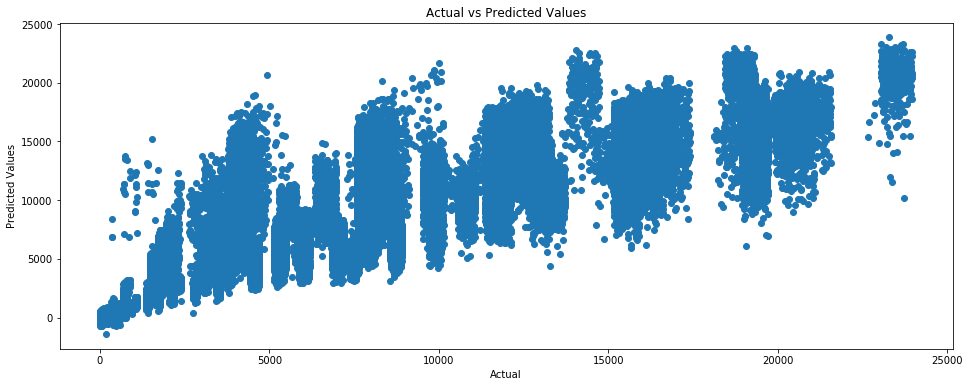

In [46]:
# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(16,6))
plt.scatter(y_validation, y_validation_predict)
plt.xlabel("Actual")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

#### Predicted Vs Residuals

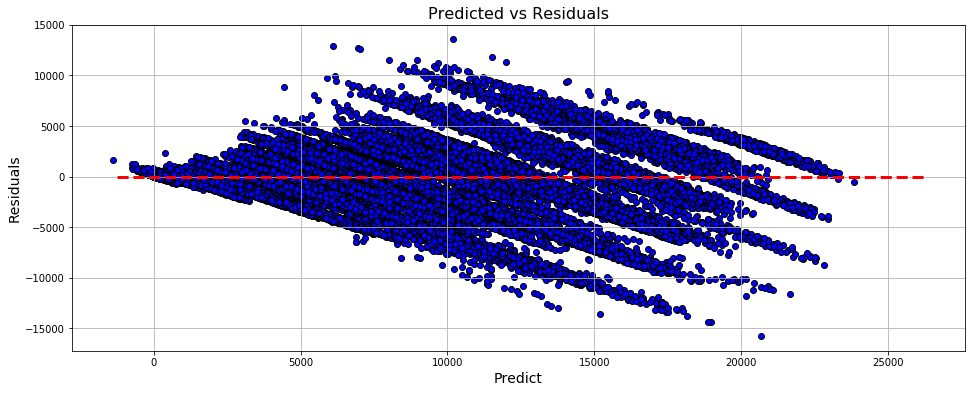

In [47]:
#### Residuals Vs Predicted Values Scatter plot ####
plt.figure(figsize=(16,6))
plt.title("{} vs Residuals".format('Predicted'),fontsize=16)
plt.scatter(x=y_validation_predict,y=residuals,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(y_validation_predict)
xmax = max(y_validation_predict)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.show()

#### Distribution of Residuals

Mean of Residuals : 10.12678789106191
Std Deviation of Residuals : 2576.781502046858


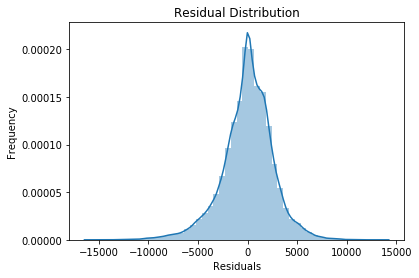

In [48]:
# Histogram Distribution of Residuals
sns.distplot(residuals)
print('Mean of Residuals :', np.mean(residuals))
print('Std Deviation of Residuals :', np.std(residuals))
plt.title('Residual Distribution')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

<Figure size 1152x432 with 0 Axes>

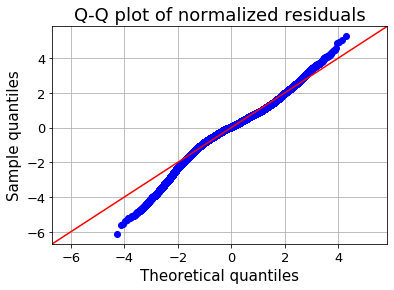

In [49]:
# Q-Q Plots of Residuals
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(16,6))
fig=qqplot(residuals,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

#### Residual Normality Test

In [50]:
# statistical normality test for validation dataset redisuals
from scipy.stats import shapiro
for i in range(10) :
    stats, pval = shapiro(residuals.sample(30))
    print(stats, pval)

0.943507969379425 0.11308106034994125
0.8959884643554688 0.006709675770252943
0.9602717161178589 0.31476280093193054
0.9609756469726562 0.32800453901290894
0.9783889651298523 0.7812892198562622
0.976006031036377 0.7123538255691528
0.9286681413650513 0.04526723176240921
0.9670237898826599 0.46127256751060486
0.9819251894950867 0.8741068243980408
0.9465065002441406 0.13620401918888092


#### Observations :
    1. Residuals follow normal distribution

#### Homoscedasticity (constant variance)  test of the Residuals

In [51]:
# Bartlett Statistical Test
### Null Hypothesis : Variances are same, Alternate Hypothesis : Variances are different, significance level = 0.05
from scipy.stats import bartlett
for i in range(10) :
    stats, pval = bartlett(residuals.sample(30), residuals.sample(30))
    print(stats, pval)

0.2329108019208719 0.629373862087958
0.0038861523217839657 0.9502928624008563
1.0782481151286871 0.29908979538454333
1.2734301447116951 0.25912417208280625
1.6221022663945577 0.2027989055355511
0.13122538292163805 0.7171648880598287
6.251550024966542 0.012408467813798002
10.7204439770181 0.0010595824488595802
0.12931647751863348 0.7191417936366249
2.136430511506159 0.14383622723807743


#### Observations :
    1. Variance among the residuals are same
    2. Residuals has constant variance

#### Cook's distance (checking for outliers in residuals)

In [ ]:
%%time
##### Cook's Distance ####
#from statsmodels.stats.outliers_influence import OLSInfluence as influence
#inf=influence(model)
##### c is Cook's Distance ####
#(c, p) = inf.cooks_distance
#plt.figure(figsize=(16,6))
#plt.title("Cook's distance plot for the residuals",fontsize=16)
#plt.stem(np.arange(len(c)), c, markerfmt=",")
#plt.grid(True)
#plt.show()

#### pickling models

In [35]:
# Linear Regression
print(joblib.dump(regressor, "linear_regressor.pkl"))

# XGBoost Regressor
print(joblib.dump(xgbr, "xgbr.pkl"))

# catboost 
print(joblib.dump(catboostr, "catboost.pkl"))

['linear_regressor.pkl']
['xgbr.pkl']
['catboost.pkl']
